In [1]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import expon
from scipy.stats import nct
from scipy.stats import chi2
from scipy.stats import hypergeom
from tqdm import tqdm

### Length of conditional/hybrid CI 

In [206]:
def cond_CI_dist(gap, alpha=0.05, eps=1e-8, step=0.5):

    if gap < 0:
        print('gap must be positive')
        return 

    def obj(L):
        return norm.logsf(L) - (np.log(alpha) + norm.logsf(-1*gap + L))
    
    L_lower = 0
    L_upper = 0
    obj_val = obj(L_upper)
    while obj_val > 0:
        L_upper += step
        obj_val = obj(L_upper)

    L = (L_lower + L_upper)/2

    while np.abs(L_upper - L_lower) > eps:
        obj_val = obj(L)
        if obj_val > 0:
            L_lower = L
            L = (L_lower + L_upper)/2
        if obj_val < 0:
            L_upper = L
            L = (L_lower + L_upper)/2

    return L
   

def hybrid_CI_dist(gap, n, alpha=0.05, beta=0.005, eps=1e-8, step=0.5):
    
    if gap < 0:
        print('gap must be positive')
        return 

    def B(alpha, n):
        return 1 - (1-alpha)**(1/n)
    
    def obj(L):
        return norm.logsf(L) - np.log( (alpha-beta)/(1-beta) * norm.sf(-1*gap + L) +  (1-alpha)/(1-beta)*B(beta, n) )
    
    L_lower = 0
    L_upper = 0
    obj_val = obj(L_upper)
    while obj_val > 0:
        L_upper += step
        obj_val = obj(L_upper)

    L = (L_lower + L_upper)/2

    while np.abs(L_upper - L_lower) > eps:
        obj_val = obj(L)
        if obj_val > 0:
            L_lower = L
            L = (L_lower + L_upper)/2
        if obj_val < 0:
            L_upper = L
            L = (L_lower + L_upper)/2

    return L




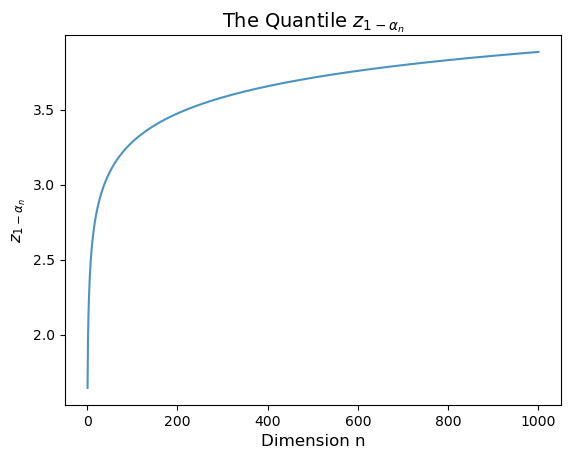

In [207]:
alpha = 0.05
alpha_ = 0.8

x = np.arange(1, 1001)
y = np.array([norm.ppf( (1-alpha) ** (1/i) ) for i in x ]) 

plt.figure()
plt.plot(x, y, alpha=alpha_)

plt.title(r"The Quantile $z_{1 - \alpha_n}$", fontsize=14)
plt.xlabel("Dimension n", fontsize=12)
plt.ylabel(r"$z_{1 - \alpha_n}$", fontsize=12)

plt.grid(False)
plt.savefig("fig/class_dist_to_winner.pdf", bbox_inches='tight', pad_inches=0)

<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
/var/folders/9b/8gtczpzd5_n_zlbsv10125gw0000gn/T/ipykernel_33830/1043066363.py:19: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("Distance $L(\cdot)$", fontsize=12)
100%|██████████| 100/100 [00:00<00:00, 455.17it/s]


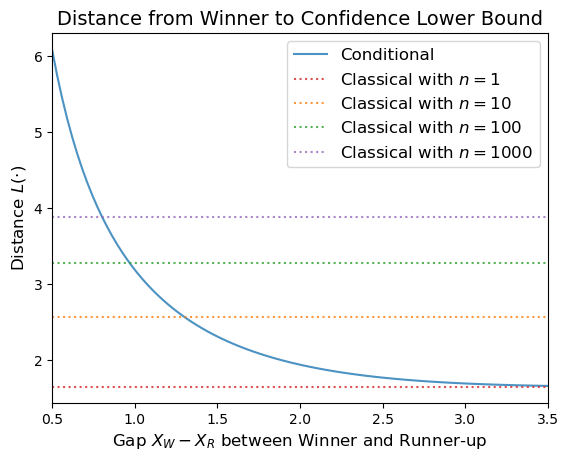

In [94]:
alpha = 0.05
alpha_ = 0.8
x_low = 0.5
x_hi = 3.5
x = np.linspace(x_low, x_hi, 100)
y = np.array([cond_CI_dist(gap) for gap in tqdm(x) ]) 

plt.figure()
plt.plot(x, y, label='Conditional', alpha=alpha_)

# Adding horizontal lines
plt.axhline(y=norm.ppf( (1-alpha) ), color='tab:red', linestyle='dotted', label='Classical with $n=1$', alpha=alpha_)
plt.axhline(y=norm.ppf( (1-alpha) ** (1/10) ) , color='tab:orange', linestyle='dotted', label='Classical with $n=10$', alpha=alpha_)
plt.axhline(y=norm.ppf( (1-alpha) ** (1/100) ), color='tab:green', linestyle='dotted', label='Classical with $n=100$', alpha=alpha_)
plt.axhline(y=norm.ppf( (1-alpha) ** (1/1000) ), color='tab:purple', linestyle='dotted', label='Classical with $n=1000$', alpha=alpha_)

plt.title("Distance from Winner to Confidence Lower Bound", fontsize=14)
plt.xlabel("Gap $X_{W} - X_{R}$ between Winner and Runner-up", fontsize=12)
plt.ylabel("Distance $L(\cdot)$", fontsize=12)
plt.xlim([x_low, x_hi ])

plt.legend(fontsize=12)

plt.grid(False)
plt.savefig("fig/cond_dist_to_winner.pdf", bbox_inches='tight', pad_inches=0)


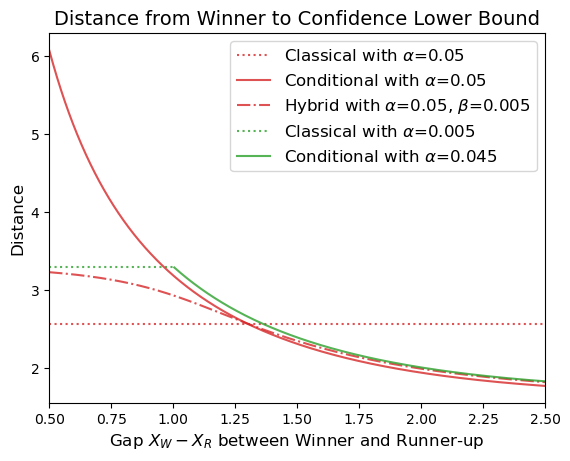

In [96]:
n = 10
alpha = 0.05
beta = alpha/10
alpha_ = 0.8
x_low = 0.5
x_hi = 2.5
x = np.linspace(x_low, x_hi, 1000)


plt.figure()

# Classical level alpha

plt.axhline(y=norm.ppf( (1-alpha) ** (1/n) ) , color='tab:red', linestyle='dotted', label=f'Classical with $\\alpha$={alpha}', alpha=alpha_)


# Conditional level alpha 
plt.plot(x, np.array([cond_CI_dist(gap, alpha=alpha) for gap in x]), color='tab:red', label=f'Conditional with $\\alpha$={alpha}', alpha=alpha_)

# Hybrid level alpha, beta 
plt.plot(x, np.array([hybrid_CI_dist(gap, n, alpha=alpha) for gap in x]) , color='tab:red', linestyle='-.', label=f'Hybrid with $\\alpha$={alpha}, $\\beta$={beta}' , alpha=alpha_)

cond_split = [cond_CI_dist(gap, alpha=alpha-beta) for gap in x]
for i in range(len(cond_split)):
    if cond_split[i] < norm.ppf( (1-beta) ** (1/n) ):
        break

# Classical level beta
plt.plot([x_low, x[i]], [norm.ppf( (1-beta) ** (1/n) ), norm.ppf( (1-beta) ** (1/n) )], color='tab:green', linestyle='dotted', label=f'Classical with $\\alpha$={beta}', alpha=alpha_)


## Conditional level alpha - beta 
plt.plot(x[i:], cond_split[i:], color = 'tab:green', label=f'Conditional with $\\alpha$={np.round(alpha-beta, 3)}', alpha=alpha_)

plt.title("Distance from Winner to Confidence Lower Bound", fontsize=14)
plt.xlabel("Gap $X_{W} - X_{R}$ between Winner and Runner-up", fontsize=12)
plt.ylabel("Distance", fontsize=12)
plt.xlim([x_low, x_hi ])

plt.legend(fontsize=12)

plt.grid(False)

plt.savefig("fig/hyb_dist_to_winner.pdf", bbox_inches='tight', pad_inches=0)


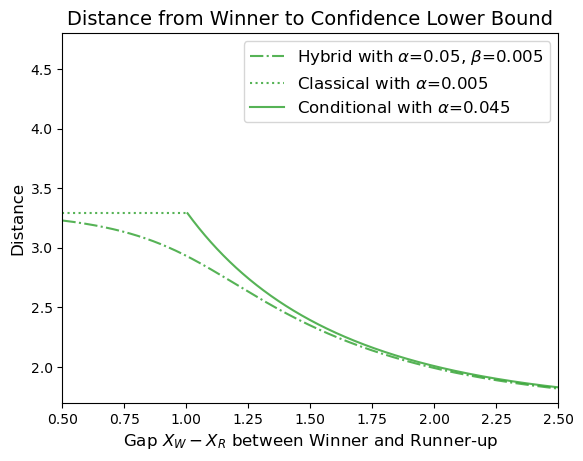

In [111]:
n = 10
alpha = 0.05
beta = alpha/10
alpha_ = 0.8
x_low = 0.5
x_hi = 2.5
x = np.linspace(x_low, x_hi, 1000)


plt.figure()

# Hybrid level alpha, beta 
plt.plot(x, np.array([hybrid_CI_dist(gap, n, alpha=alpha) for gap in x]) , color='tab:green', linestyle='-.', label=f'Hybrid with $\\alpha$={alpha}, $\\beta$={beta}' , alpha=alpha_)

cond_split = [cond_CI_dist(gap, alpha=alpha-beta) for gap in x]
for i in range(len(cond_split)):
    if cond_split[i] < norm.ppf( (1-beta) ** (1/n) ):
        break

# Classical level beta
plt.plot([x_low, x[i]], [norm.ppf( (1-beta) ** (1/n) ), norm.ppf( (1-beta) ** (1/n) )], color='tab:green', linestyle='dotted', label=f'Classical with $\\alpha$={beta}', alpha=alpha_)


## Conditional level alpha - beta 
plt.plot(x[i:], cond_split[i:], color = 'tab:green', label=f'Conditional with $\\alpha$={np.round(alpha-beta, 3)}', alpha=alpha_)

plt.title("Distance from Winner to Confidence Lower Bound", fontsize=14)
plt.xlabel("Gap $X_{W} - X_{R}$ between Winner and Runner-up", fontsize=12)
plt.ylabel("Distance", fontsize=12)
plt.xlim([x_low, x_hi ])
plt.ylim(1.7, 4.8)

plt.legend(fontsize=12)

plt.grid(False)

plt.savefig(f"fig/hyb_dist_to_winner_n={n}.pdf", bbox_inches='tight', pad_inches=0)


<>:46: SyntaxWarning: invalid escape sequence '\h'
<>:46: SyntaxWarning: invalid escape sequence '\h'
/var/folders/9b/8gtczpzd5_n_zlbsv10125gw0000gn/T/ipykernel_33830/1062092769.py:46: SyntaxWarning: invalid escape sequence '\h'
  tick_labels = ['$\hat{\mu}$', '$X_W$', '$X_R$']


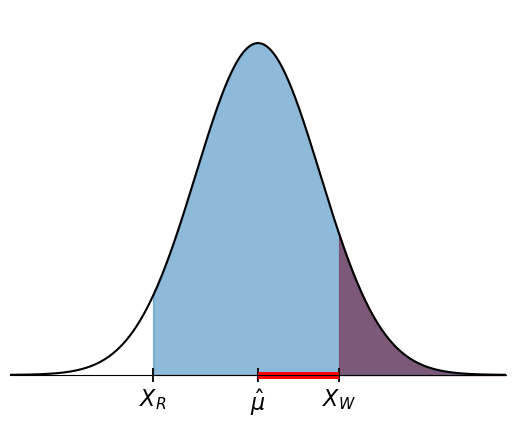

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

alpha = 0.1
x_w = 0

key_to_x_r = {3 : -0.85, 2: -1.3, 1: -3}

key =  1
x_r = key_to_x_r[key]
mu = x_w - cond_CI_dist(x_w-x_r, alpha=alpha)
sigma = 1

fig, ax = plt.subplots(figsize=([6.4, 4.8]))

# Adjust the bottom spine (x-axis) to start at y=shift
shift = 0.005
plt.gca().spines['bottom'].set_position(('data', 0.005))
plt.gca().spines['bottom'].set_color('black')  # Optional: keep the x-axis visible

# Generate x values
x_values = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
# Generate y values based on the Gaussian distribution
y_values = norm.pdf(x_values, mu, sigma) + shift

# Plot the Gaussian distribution
plt.plot(x_values, y_values, color='black')

# Shade the area under the curve to the right of x_w
x_fill = np.linspace(x_w, mu + 4*sigma, 1000)
y_fill = norm.pdf(x_fill, mu, sigma) + shift
plt.fill_between(x_fill, y_fill, y2=shift, alpha=0.9, color='tab:red')

# Shade the area under the curve to the right of x_r
x_fill = np.linspace(x_r, mu + 4*sigma, 1000)
y_fill = norm.pdf(x_fill, mu, sigma) + shift
plt.fill_between(x_fill, y_fill, y2=shift, alpha=0.5, color='tab:blue')

# Remove the top, right, and left spines (box outline)
for spine in ['top', 'right', 'left']:
    plt.gca().spines[spine].set_visible(False)


tick_positions = [mu, x_w, x_r]  
tick_labels = ['$\hat{\mu}$', '$X_W$', '$X_R$']  
plt.xticks(tick_positions, tick_labels, fontsize=16)
plt.yticks([])
ax.tick_params(axis='x', length=10, width=1.3, direction='inout', colors='black') 

correction=0.115
plt.plot([mu + correction, x_w - correction], [0, 0], color='#FF0000', linewidth=10)


# Adjust the limits to ensure annotations are visible
x_dist = x_w - min(mu, x_r)
#plt.xlim([-6, 2.4])
plt.xlim([mu - 4*sigma, mu + 4*sigma])
plt.ylim([0, max(y_values) * 1.1])

plt.savefig(f"fig/tail_prob_{key}.pdf", bbox_inches='tight', pad_inches=0)

# Show plot
plt.show()


### Hybrid Simulations

In [426]:
def B(alpha, n):
    return 1 - (1-alpha)**(1/n)

In [427]:
def union_reject(ps, alpha, beta):
    n = ps.shape[1]
    ps = np.sort(ps, axis=1)
    class_reject = ps[:, 0] < B(beta, n)
    cond_reject = ps[:, 0] < (alpha - beta) * ps[:, 1]
    reject = np.logical_or(class_reject, cond_reject)
    return reject

def hybrid_reject(ps, alpha, beta):
    n = ps.shape[1]
    ps = np.sort(ps, axis=1)
    reject = ps[:, 0] < B(beta, n) + (alpha-beta)/(1-beta) * (ps[:, 1] - B(beta, n)) 
    return reject


<>:42: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\m'
/var/folders/9b/8gtczpzd5_n_zlbsv10125gw0000gn/T/ipykernel_3672/3788381055.py:42: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$\mu_1$", fontsize=16)


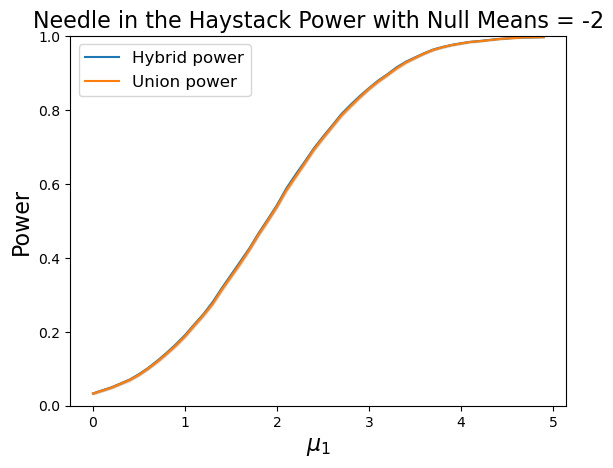

In [434]:
alpha = 0.05
beta = alpha/10
n = 10
mu1s = np.arange(0, 5, step=0.1)
mu2 = -2
sigma = np.ones(n)
sigma[0]=1
sigma[1:]=1

N, n_max = 10000, 10

X = np.random.normal(0, 1, (N, n_max)) * sigma[np.newaxis, :]

hybrid_power = []
union_power = []
class_power = []

for i in range(len(mu1s)):
        mu1 = mu1s[i] 
        X_ = X.copy()
        X_[:, 0] += mu1
        X_[:, 1:] += mu2
        ps = 1 - norm.cdf(X_ * 1/sigma[np.newaxis, :]) 
        hybrid_power.append(np.mean(hybrid_reject(ps, alpha, beta)))
        union_power.append(np.mean(union_reject(ps, alpha, beta)))

hybrid_power = np.array(hybrid_power)
union_power = np.array(union_power)

hybrid_std_dev = np.sqrt(hybrid_power * (1 - hybrid_power) / N)
hybrid_upper_bound = hybrid_power + hybrid_std_dev
hybrid_lower_bound = hybrid_power - hybrid_std_dev
plt.plot(mu1s, hybrid_power, label='Hybrid power', color='tab:blue')
plt.fill_between(mu1s, hybrid_lower_bound, hybrid_upper_bound, color='tab:blue', alpha=0.3)    

union_std_dev = np.sqrt(union_power * (1 - union_power) / N)
union_upper_bound = union_power + union_std_dev
union_lower_bound = union_power - union_std_dev
plt.plot(mu1s, union_power, label='Union power', color='tab:orange')
plt.fill_between(mu1s, union_lower_bound, union_upper_bound, color='tab:orange', alpha=0.3)    

plt.xlabel("$\mu_1$", fontsize=16)
plt.ylabel("Power", fontsize=16)
plt.title(f"Needle in the Haystack Power with Null Means = {mu2}", fontsize=16)

plt.legend(fontsize=12)
plt.ylim([0, 1])

plt.savefig(f"fig/hybrid_vs_union_null={mu2}.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

In [250]:
alpha = 0.05
beta = alpha/10
mus = np.arange(-3, 3.1, step=0.1)
sigma = np.ones(n)
sigma[0]=2
sigma[1]=1/2

N, n_max = 10000, 10

X = np.random.normal(0, 1, (N, n_max)) * sigma[np.newaxis, :]

hybrid_power = {}
union_power = {}

for i in range(len(mus)):
    for j in range(i + 1):
        mu1, mu2 = mus[i], mus[j]
        if mu1 < 0.01:
            continue
        X_ = X.copy()
        X_[:, 0] += mu1
        X_[:, 1] += mu2
        ps = 1 - norm.cdf(X_ * 1/sigma[np.newaxis, :])
        ps[:, 2:] = 1
        hybrid_power[(mu1, mu2)] = np.mean(hybrid_reject(ps, alpha, beta))
        union_power[(mu1, mu2)] = np.mean(union_reject(ps, alpha, beta))




0.02859999999999996
0.0025000000000000022
0.014600000000000035
1395


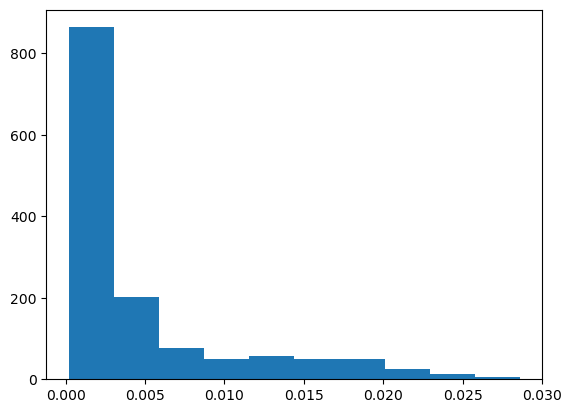

In [251]:
diffs = []
for key in union_power:
    diffs.append(hybrid_power[key] - union_power[key])
plt.hist(diffs)
print(np.max(diffs))
print(np.median(diffs))
print(np.quantile(diffs, 0.9))
print(len(diffs))

### Rank Verification and Randomization

In [496]:
# X ~ Bin(n, p1)
# Y ~ Bin(n, p2)


#test null that p1 <= p2
def binom_p_val(b, X, Y):

  num_tests = len(X)

  U = np.random.uniform(0, 1, size=num_tests)
  total=2*b
  successes=X+Y
  drawn=b

  p_val_lower = 1 - hypergeom.cdf(X, M=total, n=successes, N=drawn)
  p_val_upper = 1 - hypergeom.cdf(X - 1, M=total, n=successes, N=drawn)

  return p_val_lower + U*(p_val_upper - p_val_lower)

In [497]:
num_tests = int(1e7)
b = 4
p= 0.5
X = hypergeom.rvs(M=2*b, n=b, N=b, size=num_tests)
Y = b - X

In [498]:
n = 3
winners = np.where(X > int(b/2))[0]
winners_ = np.where(X == int(b/2) )[0]
mask = np.array(np.random.binomial(1, 1/n, size=len(winners_)), dtype=bool)
winners_ = winners_[mask]
all_winners = np.concatenate([winners, winners_])

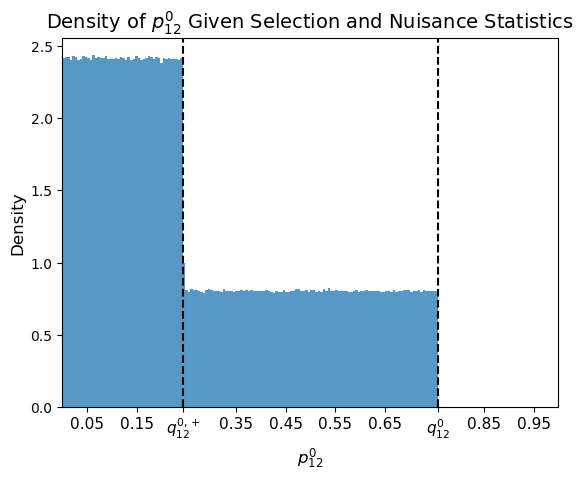

In [499]:
ps = binom_p_val(b, X[all_winners], Y[all_winners])
plt.hist(ps, bins=150, density=True, color='tab:blue', alpha=0.75)
q_plus = 1 - hypergeom.cdf(int(b/2), M=2*b, n=b , N=b)
q = 1 - hypergeom.cdf(int(b/2) - 1, M=2*b, n=b , N=b)
plt.title("Density of $p^0_{12}$ Given Selection and Nuisance Statistics", fontsize=14)
plt.ylabel("Density", fontsize=12)
plt.xlabel("$p^{0}_{12}$", fontsize=12)
plt.axvline(q, linestyle='--', color='black') 
plt.axvline(q_plus, linestyle='--', color='black') 


tick_positions = list(np.round(np.arange(0.05, 1.05, step=0.1), 2))
tick_positions.remove(0.25)
tick_positions.remove(0.75)
tick_labels = tick_positions.copy()

tick_positions += [q_plus, q]  
tick_labels += ['$q^{0, +}_{12}$', '$q^{0}_{12}$']  
plt.xticks(tick_positions, tick_labels, fontsize=11)

plt.xlim([0, 1])

plt.savefig(f"fig/p_val_density.pdf", bbox_inches='tight', pad_inches=0)

fig = plt.gcf()
figsize = fig.get_size_inches()


In [492]:
b=4
num_tests = int(1e5)
n=3
alpha = 0.1
B = np.random.binomial(b, 0.5, size=(num_tests, n))

num_winners = np.sum(B == np.max(B, axis=1).reshape(num_tests, 1), axis=1)
winners = np.argmax(B, axis = 1) 
selected = np.where(winners == 0)[0]
num_winners = num_winners[selected]
randomly_selected = np.random.binomial(1, 1/num_winners)
selected = selected[randomly_selected == 1]
num_winners = num_winners[randomly_selected == 1]
B = B[selected, :]


N = 1 + np.sum(B[: , 1:] == np.max(B[: , 1:], axis=1).reshape(len(B), 1), axis=1)
Y = B[:, 1]
X = B[:, 0]

ps = binom_p_val(b, X, Y)

cutoffs = (X + Y)/2
if n > 2:
    cutoffs = np.maximum(cutoffs, np.max(B[:, 2:], axis=1))

q_pluses = np.zeros(len(cutoffs))
qs = np.zeros(len(cutoffs))

not_integer = np.where(cutoffs != np.round(cutoffs))[0]
integer = np.where(cutoffs == np.round(cutoffs))[0]

q_pluses = 1 - hypergeom.cdf(cutoffs - 1, M=2*b, n=X+Y , N=b)

if len(not_integer) > 0:
    q_pluses[not_integer] = 1 - hypergeom.cdf(np.floor(cutoffs[not_integer]), M=2*b, n=(X+Y)[not_integer] , N=b)
    qs[not_integer] = 1 - hypergeom.cdf(np.floor(cutoffs[not_integer]), M=2*b, n=(X+Y)[not_integer] , N=b)

if len(integer) > 0:
    q_pluses[integer] = 1 - hypergeom.cdf(cutoffs[integer], M=2*b, n=(X+Y)[integer] , N=b)
    qs[integer] = 1 - hypergeom.cdf(cutoffs[integer] - 1, M=2*b, n=(X+Y)[integer], N=b)

fithian_ps = ps/qs 
my_ps = (ps - (1 - 1/N) * np.maximum(ps - q_pluses, 0))/(q_pluses + 1/N * (qs - q_pluses))



In [493]:
alpha = 0.1
fithian_error = np.mean(fithian_ps < alpha)
my_error = np.mean(my_ps < alpha)
fithian_se = np.sqrt((fithian_error * (1- fithian_error))/len(my_ps))
my_se = np.sqrt((my_error * (1- my_error))/(len(my_ps)))


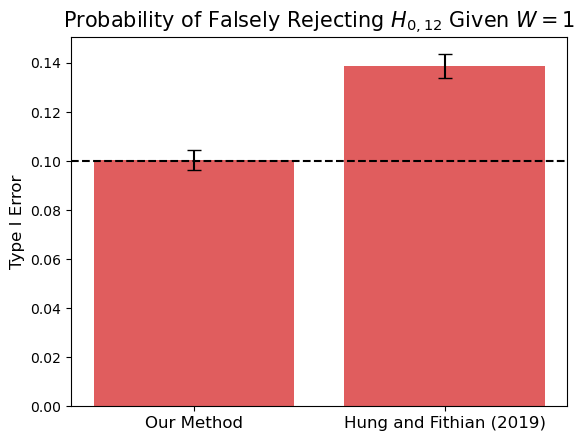

In [495]:

bar_heights = [my_error, fithian_error]
error_heights = [norm.ppf(1 - 0.01/2)*my_se, norm.ppf(1 - 0.01/2)*fithian_se]
bar_labels = ["Our Method", "Hung and Fithian (2019)"]

x_positions = np.arange(len(bar_heights))

plt.figure(figsize=figsize) 
plt.bar(x_positions, bar_heights, yerr=error_heights, capsize=5, color='tab:red', alpha=0.75)
plt.xticks(x_positions, bar_labels, fontsize=12) 

plt.axhline(y=alpha, color='black', linestyle='--')

plt.ylabel("Type I Error", fontsize=12)
plt.title("Probability of Falsely Rejecting $H_{0, 12}$ Given $W=1$", fontsize=15)

plt.savefig(f"fig/type_one_error.pdf", bbox_inches='tight', pad_inches=0)

### Rank Verification Stuff

In [125]:
N = 10000
n = 5

fithian_p = np.zeros(N)
my_p = np.zeros((N, n-1)) 
mu = np.zeros(n)
mu[0] = 2

for i in range(N):

    X = np.random.normal(0, 1, size=n) + mu
    order = np.argsort(X)
    X = X[order]
    diffs = X.reshape(-1, 1) - X.reshape(1, -1)  
    ps = 1 - norm.cdf(diffs/np.sqrt(2))
    fithian_p[i] = ps[n-1, n-2] * 2
    for j in range(n - 1):
        p = ps[-1, j]
        avg = (X[n-1] + X[j])/2 
        exclude_indices = [j, n-1]
        X_rem = np.delete(X, exclude_indices)

        # find lower bound on for (X_1 - X_j)/2
        lb1 = 0 
        lb2 = np.max(X_rem) - avg

        lb3 = -1*np.inf
        if len(X[(j+1):(n-1)]) > 0:
            lb3 = avg - np.min(X[(j+1):(n-1)])
        lb = max(lb1, lb2, lb3)

        # find upper bound on for (X_1 - X_j)/2
        ub = np.inf
        if len(X[:j]) > 0:
            ub = avg  - np.max(X[:j]) 


        # find lower and upper bound for p 
        p_upper = 1 - norm.cdf(lb * np.sqrt(2))
        p_lower = 1 - norm.cdf(ub * np.sqrt(2))

        if not p_lower < p and p < p_upper:
            print('issue')

        p_adj = (p - p_lower)/(p_upper - p_lower)
        my_p[i, j] = p_adj

fithian_power = np.mean(fithian_p < 0.05) 
my_power = np.mean(np.max(my_p, axis=1) < 0.05) 
my_power = np.mean(my_p[:, -1] < 0.05) 


print(fithian_power, my_power)

### Randomized Selection

In [1]:
def f(x, u, other_ps, gamma):
    probs = 1 - (gamma/(1-gamma) * (x - other_ps) + u)
    probs = np.minimum(np.maximum(0, probs), 1)
    if np.any(probs == 0):
        return 0
    return np.exp(np.sum(np.log(probs)))

def p_adj(p, other_ps, gamma):
    num = integrate.dblquad(f, a=0, b=1, gfun=0, hfun=p, args=(other_ps, gamma))[0]
    den = integrate.dblquad(f, a=0, b=1, gfun=0, hfun=1, args=(other_ps, gamma))[0]
    return num/den

In [3]:
N = 1000
n=10
gamma = 1/2
ps = np.random.uniform(0, 1, size=n)
select = 0
us = np.zeros(n)
us[0] = np.random.uniform(0, 1)

for i in range(N):
    us[1:] = np.random.uniform(0, 1, size=n-1)
    qs = gamma * ps + (1 - gamma) * us 
    if np.argmin(qs) == 0:
        select += 1

print(select/N)
print(f(ps[0], us[0], ps[1:], gamma))



0.0119
0.01276921146252774


In [4]:
n = 10
N = 1000
gamma = 1/2
X = np.random.normal(0, 1, size=(N, n))
ps = 1 - norm.cdf(X)
U = np.random.uniform(0, 1, size=(N, n))
qs = gamma * ps + (1 - gamma) * U
sorted_ps = np.zeros(ps.shape)

for i in range(N):
    sorted_ps[i, :] = ps[i, np.argsort(qs[i, :])]

In [6]:
p_adjs = np.zeros(N)
for i in tqdm(range(N)):  
    p_adjs[i] = p_adj(sorted_ps[i, 0], sorted_ps[i, 1:], gamma)

  0%|          | 0/1000 [00:00<?, ?it/s]


KeyboardInterrupt: 

### Fisher's combination test

<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
/var/folders/9b/8gtczpzd5_n_zlbsv10125gw0000gn/T/ipykernel_3672/805463311.py:63: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Value of the Signals $\mu_1 = \dots = \mu_{\ell}$", fontsize=14)


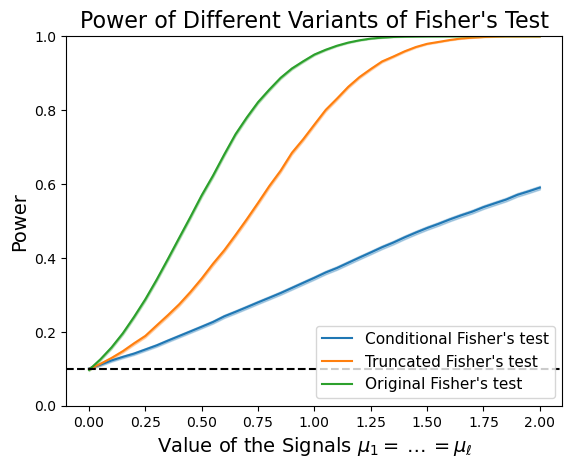

In [589]:
N = int(1e4)
n = 10 
ell = 10
alpha=0.1

mu_null = -2

tau = 0.5
k = 3
mus = np.arange(0, 2.05, step=0.05)

X = np.random.normal(0, 1, size=(N, n))

cond_power = np.zeros(len(mus))
trunc_power = np.zeros(len(mus))
orig_power = np.zeros(len(mus))

for i, mu in enumerate(mus):
    X_ = X.copy()
    X_[:, :ell] += mu
    X_[:, ell:] += mu_null 
    ps = 1 - norm.cdf(X_)
    ps = np.sort(ps, axis=1)

    orig_stats = -2*np.sum(np.log(ps), axis=1)
    orig_crit_val = chi2.ppf(1-alpha, df=2*n)
    orig_power[i] = np.mean(orig_stats > orig_crit_val)

    # conditional

    cond_stats = -2*np.sum(np.log(ps[:, :k]/ps[:, k].reshape(N, 1)), axis=1)
    cond_crit_val = chi2.ppf(1-alpha, df=2*k)
    cond_power[i] = np.mean(cond_stats > cond_crit_val)

    # trunc 

    below = ps < tau
    trunc_stats = -2*np.sum(np.log(ps/tau) * below, axis=1)
    num_selected = np.sum(below, axis = 1)
    trunc_crit_val = chi2.ppf(1-alpha, df=2*num_selected)
    trunc_power[i] = np.mean(trunc_stats > trunc_crit_val)



cond_std_dev = np.sqrt(cond_power * (1 - cond_power) / N)
cond_upper_bound = cond_power + cond_std_dev
cond_lower_bound = cond_power - cond_std_dev
plt.plot(mus, cond_power, label="Conditional Fisher's test", color='tab:blue')
plt.fill_between(mus, cond_lower_bound, cond_upper_bound, color='tab:blue', alpha=0.3)    

trunc_std_dev = np.sqrt(trunc_power * (1 - trunc_power) / N)
trunc_upper_bound = trunc_power + trunc_std_dev
trunc_lower_bound = trunc_power - trunc_std_dev
plt.plot(mus, trunc_power, label="Truncated Fisher's test", color='tab:orange')
plt.fill_between(mus, trunc_lower_bound, trunc_upper_bound, color='tab:orange', alpha=0.3)    

orig_std_dev = np.sqrt(orig_power * (1 - orig_power) / N)
orig_upper_bound = orig_power + orig_std_dev
orig_lower_bound = orig_power - orig_std_dev
plt.plot(mus, orig_power, label="Original Fisher's test", color='tab:green')
plt.fill_between(mus, orig_lower_bound, orig_upper_bound, color='tab:green', alpha=0.3)   

plt.xlabel("Value of the Signals $\mu_1 = \dots = \mu_{\ell}$", fontsize=14)
plt.ylabel("Power", fontsize=14)
plt.title(f"Power of Different Variants of Fisher's Test", fontsize=16)
plt.ylim([0,1])


plt.legend(fontsize=11)
plt.axhline(alpha, linestyle='--', color='black')

plt.savefig(f"fig/fisher_ell={ell}.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

### Gap Testing

In [ ]:
def B(alpha, n):
    return 1 - (1-alpha)**(1/n)

n = 20 
alpha = 0.05
N = int(1000) 
X = np.random.normal(0, 1, size=(N, n))

mu_signal = 3
mu_null = -3 

ks = np.arange(10)
class_power = np.zeros(len(ks))
cond_power = np.zeros(len(ks))
ratio_power = np.zeros(len(ks))
for i, k in enumerate(ks):
    mu = np.ones(n)
    mu[:k] *= mu_signal
    mu[k:] *= mu_null
    X += mu.reshape(1, n)
    ps = 1 - norm.cdf(X)

    ps = np.sort(ps, axis=1)

    class_reject = np.mean(ps[:, 0] <= B(alpha, n))
    cond_reject = np.mean(ps[:, 0]/ps[:, 1] <= alpha)

    ps_offset = np.zeros(ps.shape)
    ps_offset[: , :(n-1)] = ps[:, 1:].copy()
    ratios = ps/ps_offset 
    ratio_winners = np.argmin(ratios, axis=1)
    ratios[np.arange(N), ratio_winners] = np.inf
    second_ratios = np.min(ratios, axis=1)
    ps_offset = np.concatenat()
    ratio_winners += 1
    ratio_reject = ps[np.arange(N), ratio_winners] <= alpha * second_ratios * ps[np.arange(N), ratio_winners + 1] + (1-alpha)* ps[np.arange(N), ratio_winners - 1]
    ratio_power = np.mean(ratio_reject)
